In [1]:
import torchvision
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
import cv2
from diffusers import UNet2DModel
from diffusers import AutoencoderKL
from diffusers import DDPMScheduler, DPMSolverMultistepScheduler, DDIMScheduler
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers import DDPMPipeline
from diffusers import StableDiffusionPipeline
from PIL import Image
import json
import create_init_unet
import pathlib
import copy
import wandb
device = "cuda"
VAE_SCALE_FACTOR = 0.18215

e:\Projects\venvs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pipe = DDPMPipeline.from_pretrained("model/s2i_celeba_1epoch").to("cuda")

In [4]:
class FineTuningDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        super().__init__()

        self.data_dir = pathlib.Path(data_dir)
        self.images_path = [str(p) for p in self.data_dir.iterdir()]

        self.to_normalized_tensor = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ]
        )

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, index):
        image_path = self.images_path[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sketch = self.create_sketch(image)

        image_tensor = self.to_normalized_tensor(image)
        sketch_tensor = self.to_normalized_tensor(sketch)

        return image_tensor, sketch_tensor
    
    def create_sketch(self, image):
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_canny = cv2.Canny(image_gray, 100, 200)
        return image_canny



In [6]:
dataset = FineTuningDataset("./data/celeba_hq_256")
dataloader = DataLoader(dataset, batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


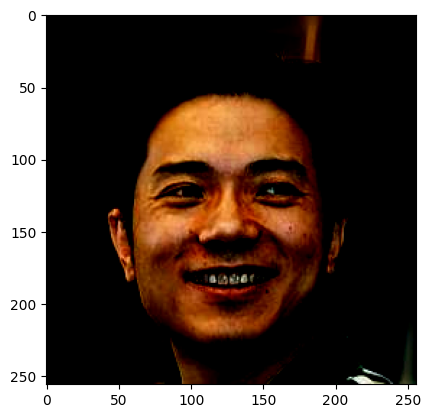

In [8]:
image, sketch = next(iter(dataloader))

In [11]:
sketches = sketch.to("cuda")
images = torch.randn((1,3,256,256)).to("cuda")

for t in tqdm(pipe.scheduler.timesteps):
    model_input = torch.concat([images, sketches], dim=1).to("cuda")
    with torch.no_grad():
        model_output = pipe.unet(model_input, t).sample
    images = pipe.scheduler.step(model_output, t, images).prev_sample


100%|██████████| 1000/1000 [02:48<00:00,  5.93it/s]


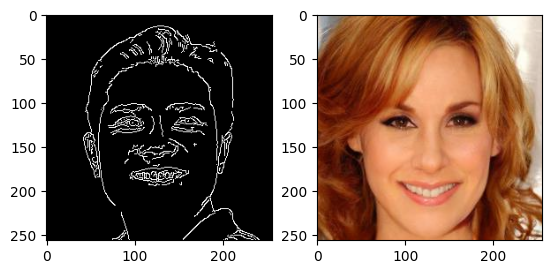

In [26]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(sketches[0].permute(1,2,0).cpu().numpy() * 0.5 + 0.5, "gray")
axs[1].imshow(images[0].permute(1,2,0).cpu().numpy() * 0.5 + 0.5)

In [24]:
print(pipe.unet.conv_in.weight[4][3])

tensor([[-1.2247e-04, -1.0118e-04, -1.1041e-05],
        [-2.0723e-04, -2.3850e-04, -1.8107e-04],
        [-1.9293e-04, -1.7037e-05, -5.2956e-05]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [7]:

def train(dataset):
    # define configs
    save_path = "model/celeba_test"
    pretrained_model_name_or_path = "model/init_s2i_celeba"
    batch_size = 1
    lr = 1e-5
    num_epochs = 2
    grad_accumulation_steps = 2
    train_dataset_rate = 0.001
    device = "cuda"

    # wandb initizalize
    config = dict(
        batch_size=batch_size,
        lr=lr,
        grad_accumulation_steps=grad_accumulation_steps,
        num_epochs=num_epochs,
        device=device,
        train_dataset_rate=train_dataset_rate,
    )
    wandb.init(project="ddpm_train_test", config=config)

    # load pipe
    pipe = DDPMPipeline.from_pretrained(
        pretrained_model_name_or_path=pretrained_model_name_or_path
    ).to(device)

    # split dataset
    dataset_len = int(len(dataset) * train_dataset_rate)
    dataset, _ = torch.utils.data.random_split(
        dataset, [dataset_len, len(dataset) - dataset_len]
    )

    # train
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=lr)

    for epoch in range(num_epochs):
        print(epoch)
        for step, (image, sketch) in enumerate(tqdm(dataloader)):
            bs = image.shape[0]

            # prepare valiables
            image = image.to(device)
            sketch = sketch.to(device)
            noise = torch.randn_like(image).to(device)
            timesteps = torch.randint(
                0, pipe.scheduler.num_train_timesteps, (bs,), device=device
            ).long()

            # set up model input
            noisy_image = pipe.scheduler.add_noise(image, noise, timesteps)
            model_input = torch.cat([noisy_image, sketch], dim=1).to(device)

            # prediction
            noise_pred = pipe.unet(model_input, timesteps).sample

            # backward
            loss = F.mse_loss(noise_pred, noise)
            loss.backward(loss)

            # optimizer's step
            if (step + 1) % grad_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            # logging
            wandb.log({"loss": loss.item()})
    # save
    pipe.save_pretrained(save_path)

dataset = FineTuningDataset("data/celeba_hq_256")
train(dataset)

0


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


1


100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


In [4]:
import time
dataset = FineTuningDataset("data/celeba_hq_256")
dataloader = DataLoader(dataset, 4, shuffle=True, num_workers=2)
for x, y in tqdm(dataloader):
    time.sleep(0.01) 
    pass

  0%|          | 0/7500 [00:00<?, ?it/s]

In [27]:
pipe.to(device)

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.11.1",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [28]:
pipe()

  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 1

In [27]:
pipe.__init__()

TypeError: DDPMPipeline.__init__() missing 2 required positional arguments: 'unet' and 'scheduler'

In [22]:
d["in_channels"] = 4
print(pipe.unet.config)

FrozenDict([('sample_size', 256), ('in_channels', 3), ('out_channels', 3), ('center_input_sample', False), ('time_embedding_type', 'positional'), ('freq_shift', 1), ('flip_sin_to_cos', False), ('down_block_types', ['DownBlock2D', 'DownBlock2D', 'DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D', 'DownBlock2D']), ('up_block_types', ['UpBlock2D', 'AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D', 'UpBlock2D', 'UpBlock2D']), ('block_out_channels', [128, 128, 256, 256, 512, 512]), ('layers_per_block', 2), ('mid_block_scale_factor', 1), ('downsample_padding', 0), ('act_fn', 'silu'), ('attention_head_dim', None), ('norm_num_groups', 32), ('norm_eps', 1e-06), ('resnet_time_scale_shift', 'default'), ('add_attention', True), ('_class_name', 'UNet2DModel'), ('_diffusers_version', '0.11.1'), ('_name_or_path', 'E:\\SD_models\\diffusers\\ddpm-celebahq-256\\unet')])


In [ ]:
create_init_unet.create_diffusers_init_unet(
    r"E:\SD_models\diffusers\ddpm-celebahq-256\unet",

)

In [36]:
scheduler =  DPMSolverMultistepScheduler.from_pretrained("E:\SD_models\diffusers\ddpm-celebahq-256\scheduler")
scheduler.set_timesteps(num_inference_steps=5)
image_pipe = pipe

In [39]:
# The random starting point
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256 x 256 px images

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare model input
    model_input = scheduler.scale_model_input(x, t)

    # Get the prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Calculate what the updated sample should look like with the scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # Update x
    x = scheduler_output.prev_sample

5it [00:02,  1.74it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


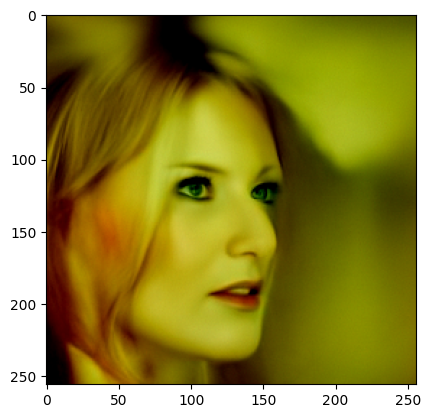

In [40]:
plt.imshow(x[0].cpu().permute(1,2,0).numpy())

In [44]:
d = json.load(r"E:\SD_models\diffusers\ddpm-celebahq-256\unetE:\SD_models\config.json")

AttributeError: 'str' object has no attribute 'read'

In [49]:
with open(r"E:\SD_models\diffusers\ddpm-celebahq-256\unet\config.json") as f:
    d = json.load(f)

In [54]:
d["in_channels"]

3

In [59]:
a = {
    "hoge":1,
    "moge":2,
}
b = a
a["toge"] = 3
print(a, b)

{'hoge': 1, 'moge': 2, 'toge': 3} {'hoge': 1, 'moge': 2, 'toge': 3}
